In [2]:
import json
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import random

### Hyperparameters

In [3]:
# the number of objects in each world
WORLD_SIZE = 5

# the dimension of the feature vector of each object
# as produced by the encoder
OBJECT_FEATURE_DIMENSION = 6

# the dimension of the speaker's generated vector representation
NEURALESE_DIMENSION = 12

### Model Components

In [4]:
class ObjectEncoder(nn.Module):
    """
    Encodes a single (3x3) Object into a feature vector
    Input     : [[001][100][010]] or Purple-Cirle-No-Outline. See metadata.json
    InputSize : (3,3)
    OutputSize: (OBJECT_FEATURE_DIMENSION)
    """
    def __init__(self, output_dimension=OBJECT_FEATURE_DIMENSION):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size=2),  # → (batch, 4, 2, 2)
            nn.Flatten(),                    # → (batch, 16)
            nn.Linear(16, output_dimension)
        )
        
    def forward(self, x):
        return self.encoder(x)

In [5]:
class Speaker(nn.Module):
    """
    Transforms the encoded objects in world W + boolean inclusion mask for target subset X 
    into a representative vector
    
    InputSize : (WORLD_SIZE * OBJECT_FEATURE_DIMENSION) + WORLD_SIZE)
    OutputSize: (NEURALESE_DIMENSION)
    """
    def __init__(self, input_dimension=(WORLD_SIZE * OBJECT_FEATURE_DIMENSION) + WORLD_SIZE, 
                 output_dimension=NEURALESE_DIMENSION):
        super().__init__()
        self.speaker_net = nn.Sequential(
            nn.Linear(input_dimension, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, output_dimension)
        )
    
    def forward(self, x):
        return self.speaker_net(x)

In [6]:
class Listener(nn.Module):
    """
    Takes the resultant vector from the speaker, along with W_i (an element of the world W)
    and predicts whether this element belongs to X, the target subset.
    
    InputSize : (NEURALESE_DIMENSION + OBJECT_FEATURE_DIMENSION)
    OutputSize: (1) -> logit for binary classification
    """
    def __init__(self, input_dimension=NEURALESE_DIMENSION + OBJECT_FEATURE_DIMENSION, 
                 output_dimension=1):
        super().__init__()
        self.listener_net = nn.Sequential(
            nn.Linear(input_dimension, 32),
            nn.ReLU(),
            nn.Linear(32, 8),
            nn.ReLU(),
            nn.Linear(8, output_dimension)
        )
            
    def forward(self, x):
        return self.listener_net(x)
            

In [7]:
class SpeakerListenerSystem(nn.Module):
    """
    The end-to-end system.
    Encoder -> Speaker -> Listener
    """
    def __init__(self, world_size, feature_dimension, neuralese_dimension):
        super().__init__()
        
        self.world_size          = world_size
        self.feature_dimension   = feature_dimension
        self.neuralese_dimension = neuralese_dimension
        
        speaker_input_size  = (self.world_size * self.feature_dimension) + self.world_size
        listener_input_size = self.neuralese_dimension + self.feature_dimension
        
        self.encoder  = ObjectEncoder(output_dimension=self.feature_dimension)
        self.speaker  = Speaker(input_dimension=speaker_input_size, output_dimension=neuralese_dimension)
        self.listener = Listener(input_dimension=listener_input_size, output_dimension=1)
        
        
    def forward(self, W, X_mask):
        """
        W:      A batch of worlds. 
                Each world is a set of (3x3) objects.
                Tensor of shape (batch_size, world_size, 3, 3).
                
        X_mask: A batch of boolean masks
                Each value indicated whether the object at that index in W
                is included in the target subset X
                Tensor of shape (batch_size, world_size)
        """
        batch_size = W.shape[0]
        
        ### STEP 1: Encode all objects in the world
        # Reshape for batch processing ny the encoder (B, 5, 3, 3) -> (B*5, 1, 3, 3)
        W_flat = W.view(-1, 1, 3, 3)
        # Get features for all objects: (B*5, feature_dim)
        object_features_flat = self.encoder(W_flat)
        # Reshape back to per-batch item:(B, 5, feature_dim)
        object_features = object_features_flat.view(batch_size, self.world_size, self.feature_dimension)
        
        
        ### STEP 2: Assemble the inputs to the speaker model
        # Flatten object features: (B, 5, feature_dim) -> (B, 5*feature_dim)
        V_W =  object_features.view(batch_size, -1)
        # Create the indicator mask
        M_X = X_mask
        # Concatenate features and mask
        speaker_input = torch.cat([V_W, M_X], dim=1)
        
        
        ### STEP 3: Speaker generates neuralese
        # representation has shape (B, neuralese_dimension)
        representation = self.speaker(speaker_input)
        
        ### STEP 4: Prepare the listener's input
        # The listener needs to pair the speaker's representation with each object feature
        # Expand the representation to match the number of objects
        # (B, rep_dim) -> (B, 1, rep_dim) -> (B, world_size, rep_dim)
        r_expanded = representation.unsqueeze(1).repeat(1, self.world_size, 1)
        # Concatenate with object features: (B, 5, rep_dim) + (B, 5, feature_dim)
        listener_input = torch.cat([r_expanded, object_features], dim=2)
        
        
        ### STEP 5: Shuffle inputs to the listener
        # This is to avoid the speaker simply learning to tell the listener about X_mask
        # without learning anything about the objects in X themselves.
        # Create a random permutation for each item in the batch
        shuffled_indices = [torch.randperm(self.world_size) for _ in range(batch_size)]
        # Apply the shuffle
        shuffled_input   = torch.stack([features[p] for features, p in zip(listener_input, shuffled_indices)])
        shuffled_labels  = torch.stack([labels[p]   for labels,   p in zip(X_mask, shuffled_indices)])
        
        
        ### STEP 6: Listener makes an inclusion prediction for each object
        # Reshape for batch processing by the listener
        # (B, 5, rep_dim + feature_dim) -> (B*5, rep_dim + feature_dim)
        listener_input_flat = shuffled_input.view(-1, self.neuralese_dimension + self.feature_dimension)
        # Get predictions (logits) -> (B*5, 1)
        predictions_flat = self.listener(listener_input_flat)
        # Reshape back to (B, world_size)
        predictions = predictions_flat.view(batch_size, self.world_size)
        
        return predictions, shuffled_labels

In [8]:
class Translator(nn.Module):
    """
    Translates neuralese representation V into natural language rule R.

    Takes the learned communication vector V (produced by the speaker) and 
    predicts the original rule R as a fixed-length sequence of tokens.
    Each position in the sequence is predicted independently via classification 
    over the vocabulary (features, logical operators, and blank token).
    """
    def __init__(self, neuralese_dimension=NEURALESE_DIMENSION, 
                 max_rule_length=3, vocab_size=13, hidden_dimension=128):
        super().__init__() 
        self.max_rule_length     = max_rule_length
        self.neuralese_dimension = neuralese_dimension
        self.vocab_size          = vocab_size

        self.translation_net = nn.Sequential(
            nn.Linear(neuralese_dimension, hidden_dimension),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dimension, hidden_dimension),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dimension, max_rule_length * vocab_size)
        )
            
        
    def forward(self, V):
        """
        Arguments:
        V : A batch of neuralese representations (batch_size,  neuralese_dimension)

        Returns:
        logits : (batch_size, max_rule_length, vocab_size)
        """
        batch_size = V.shape[0]

        output = self.translation_net(V)  # (batch_size, max_rule_length * vocab_size)
        logits = output.view(batch_size, self.max_rule_length, self.vocab_size)

        return logits
    
# Alternative architectures to consider:

# Autoregressive (if you want token dependencies):
# Use an RNN/LSTM that generates one token at a time
# token_1 depends only on V
# token_2 depends on V and token_1, etc.

# Deeper MLP with position embeddings:
# Add learnable position embeddings to help the model 
# know which position it's predicting

### Data Loading

In [9]:
def generate_batch(batch_size, world_size):
    """Generates a batch of dummy data"""
    
    # Random 3x3 objects for the world
    W_batch = torch.rand(batch_size, world_size, 3, 3)
    
    # Random binary masks
    X_mask_batch = torch.randint(0, 2, (batch_size, world_size)).float()
    
    # Ensure at least one object is selected in each world
    for i in range(batch_size):
        if X_mask_batch[i].sum() == 0:
            # Randomly select one object
            X_mask_batch[i, random.randint(0, world_size-1)] = 1.0
    
    
    return W_batch, X_mask_batch

In [10]:
def load_dataset(path='dataset.npz'):
    """Load the real dataset from npz file"""
    
    data = np.load(path, allow_pickle=True)
    
    W = data['W']
    X_mask = data['X_mask']
    rule_encodings = data['rule_encodings']
    rule_texts = data['rule_texts']
    
    # Load metadata
    metadata_path = path.replace('.npz', '_metadata.json')
    with open(metadata_path, 'r') as f:
        metadata = json.load(f)
    
    return W, X_mask, rule_encodings, rule_texts, metadata

In [11]:
def split_dataset(W, X_mask, rule_encodings, rule_texts, 
                speaker_listener_ratio=0.5,
                translator_train_ratio=0.4,
                translator_test_ratio =0.1,
                seed=42):
    
    """
    Split dataset into three portions with shuffling:
    1. Speaker-Listener training (50%)
    2. Translator training (40%)
    3. Translator testing (10%)
    
    Args:
        W: World matrices [N, 5, 3, 3]
        X_mask: Subset masks [N, 5]
        rule_encodings: Rule encodings [N, ...]
        rule_texts: Rule text strings [N]
        speaker_listener_ratio: Fraction for speaker-listener
        translator_train_ratio: Fraction for translator training
        translator_test_ratio: Fraction for translator testing
        seed: Random seed for reproducibility
    
    Returns:
        Dictionary with all splits
    """
    
    assert abs(speaker_listener_ratio + translator_train_ratio + translator_test_ratio - 1.0) < 1e-6, \
           "Ratios must sum to 1.0"
    np.random.seed(seed)

    # Shuffle the dataset
    N_total = len(W)
    indices = np.random.permutation(N_total)

    # Calculate sizes of data portions
    speaker_listener_size = int(N_total * speaker_listener_ratio)
    translator_train_size = int(N_total * translator_train_ratio)
    translator_test_size  = int(N_total * translator_test_ratio)

    # Calculate indices for splitting
    speaker_listener_idx = indices[:speaker_listener_size]
    translator_train_idx = indices[speaker_listener_size:speaker_listener_size + translator_train_size]
    translator_test_idx  = indices[speaker_listener_size + translator_train_size:]

    # Split the data
    split_dataset = {
        'speaker_listener': {
            'W':              torch.tensor(W[speaker_listener_idx]).float(),
            'X_mask':         torch.tensor(X_mask[speaker_listener_idx]).float(),
            'rule_encodings': rule_encodings[speaker_listener_idx],
            'rule_texts':     rule_texts[speaker_listener_idx]
        },
        'translator_train': {
            'W':              torch.tensor(W[translator_train_idx]).float(),
            'X_mask':         torch.tensor(X_mask[translator_train_idx]).float(),
            'rule_encodings': rule_encodings[translator_train_idx],
            'rule_texts':     rule_texts[translator_train_idx]
        },
        'translator_test': {
            'W':              torch.tensor(W[translator_test_idx]).float(),
            'X_mask':         torch.tensor(X_mask[translator_test_idx]).float(),
            'rule_encodings': rule_encodings[translator_test_idx],
            'rule_texts':     rule_texts[translator_test_idx]
        }
    }

    print("Dataset Split:")
    print(f"  Speaker-Listener:  {len(speaker_listener_idx):,} ({speaker_listener_ratio*100:.0f}%)")
    print(f"  Translator Train:  {len(translator_train_idx):,} ({translator_train_ratio*100:.0f}%)")
    print(f"  Translator Test:   {len(translator_test_idx):,}  ({translator_test_ratio*100:.0f}%)")
    print(f"  Total:             {N_total:,}")

    return split_dataset

In [12]:
# Load dataset and split
W_data, X_mask_data, rule_encodings_data, rule_texts_data, metadata = load_dataset('dataset.npz')
dataset_splits = split_dataset(W_data, X_mask_data, rule_encodings_data, rule_texts_data)

def load_batch(split_name, start_idx, batch_size):
    """Load a batch of data from the specified split"""
    split = dataset_splits[split_name]
    end_idx = start_idx + batch_size
    return split['W'][start_idx:end_idx], split['X_mask'][start_idx:end_idx]

Dataset Split:
  Speaker-Listener:  852,916 (50%)
  Translator Train:  682,333 (40%)
  Translator Test:   170,584  (10%)
  Total:             1,705,833


### Visualizations

In [13]:
def plot_metric(values, step_size, metric_name, save_path=None, figsize=(10,6)):
    """
    Plot training metric (loss or accuracy) over epochs

    Args:
        values: List or array of metric values recorded during training
        step_size: Number of epochs between each recorded value (e.g., 50 if you log every 50 epochs)
        metric_name: Name of the metric for labels (e.g., 'Loss', 'Accuracy')
        save_path: Optional path to save the figure (e.g., 'speaker_loss.png')
        figsize: Tuple specifying figure size (width, height)
    
    Example:
        plot_metric(losses, 50, 'Loss', save_path='speaker_loss.png')
        plot_metric(accuracies, 50, 'Accuracy', save_path='speaker_accuracy
    """
    
    # Calculate epochs based on step size
    epochs = np.arange(step_size, len(values)*step_size + 1, step_size)

    # Create the plot
    plt.figure(figsize=figsize)
    plt.plot(epochs, values, linewidth=2, color="#B41F1F" if 'loss' in metric_name.lower() else "#35B457")

    # Styling 
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel(metric_name, fontsize=12)
    plt.title(f'{metric_name} over Training', fontsize=14)

    # Tight layout for better spacing
    plt.tight_layout()
    
    # Save if path provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved to {save_path}")
    
    plt.show()

## The  Speaker Listener

### Training

In [18]:
# Hyperparameters for training
BATCH_SIZE    = 32 # 32
NUM_EPOCHS    = 10_000 # 2000
LEARNING_RATE = 1e-4

In [19]:
# Instantiate the system
model = SpeakerListenerSystem(
    world_size          = WORLD_SIZE,
    feature_dimension   = OBJECT_FEATURE_DIMENSION,
    neuralese_dimension = NEURALESE_DIMENSION,
)

In [20]:
# Use BCEWithLogitsLoss because our model outputs raw logits (more stable)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

epoch = 0
start_index = 0
N_DATA = len(dataset_splits['speaker_listener']['W'])

losses = []
accuracies = []

print("Starting training...")
while True:
    epoch += 1
    
    # Generate a new batch of dummy data
    # W, X_mask = generate_batch(BATCH_SIZE, WORLD_SIZE)

    # Load real data
    W, X_mask = load_batch('speaker_listener', start_index, BATCH_SIZE)
    start_index += BATCH_SIZE
    if start_index + BATCH_SIZE > N_DATA:
        print("Reached end of training data.")
        break
    
    # Forward pass - y_truth is the shuffled X_mask
    optimizer.zero_grad()
    y_logits, y_truth = model(W, X_mask)
    
    # Calculate loss - (y_truth serves as the ground truth)
    loss = criterion(y_logits, y_truth)
    
    # Backward pass and optimize
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 50 == 0:
        # Track data consumption
        print(f"start_index: {start_index}, end_index: {start_index + BATCH_SIZE}")

        # Calculate accuracy for monitoring
        preds    = torch.sigmoid(y_logits) > 0.5
        accuracy = (preds.float() == y_truth).float().mean() 
        print(f"Epoch [{epoch+1}/---], Loss: {loss.item():.4f}, Accuracy: {accuracy.item():.4f}")

        # Store metrics
        losses.append(loss.item())
        accuracies.append(accuracy.item())
        
print("Training finished.")

Starting training...
start_index: 1568, end_index: 1600
Epoch [50/---], Loss: 0.7021, Accuracy: 0.4625
start_index: 3168, end_index: 3200
Epoch [100/---], Loss: 0.6912, Accuracy: 0.5250
start_index: 4768, end_index: 4800
Epoch [150/---], Loss: 0.6935, Accuracy: 0.4938
start_index: 6368, end_index: 6400
Epoch [200/---], Loss: 0.6944, Accuracy: 0.3875
start_index: 7968, end_index: 8000
Epoch [250/---], Loss: 0.6867, Accuracy: 0.6625
start_index: 9568, end_index: 9600
Epoch [300/---], Loss: 0.6809, Accuracy: 0.6500
start_index: 11168, end_index: 11200
Epoch [350/---], Loss: 0.6623, Accuracy: 0.6875
start_index: 12768, end_index: 12800
Epoch [400/---], Loss: 0.6507, Accuracy: 0.6562
start_index: 14368, end_index: 14400
Epoch [450/---], Loss: 0.6443, Accuracy: 0.6500
start_index: 15968, end_index: 16000
Epoch [500/---], Loss: 0.6119, Accuracy: 0.6812
start_index: 17568, end_index: 17600
Epoch [550/---], Loss: 0.6161, Accuracy: 0.6687
start_index: 19168, end_index: 19200
Epoch [600/---], Los

Plot saved to speaker_loss.png


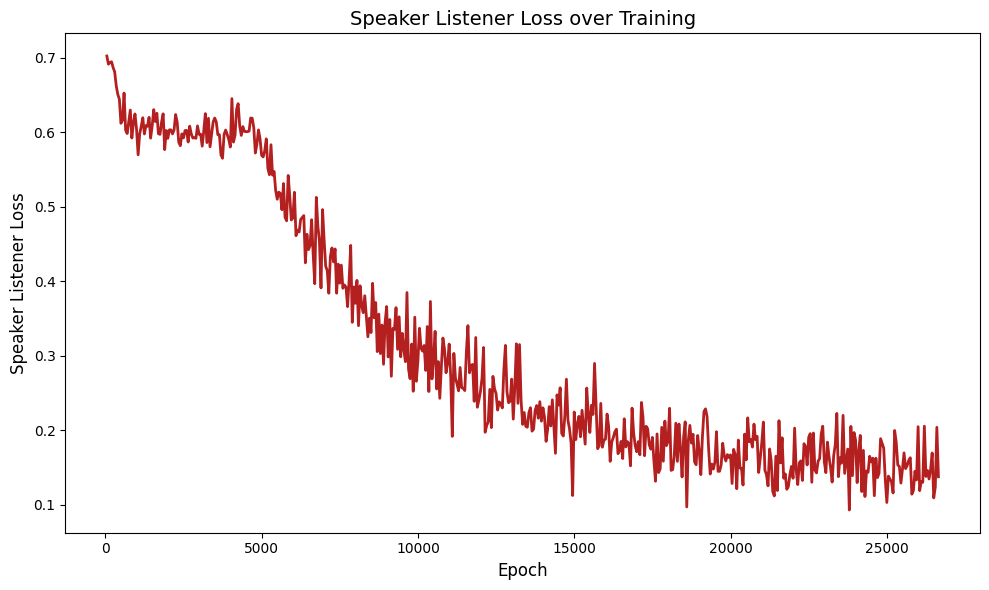

Plot saved to speaker_accuracy.png


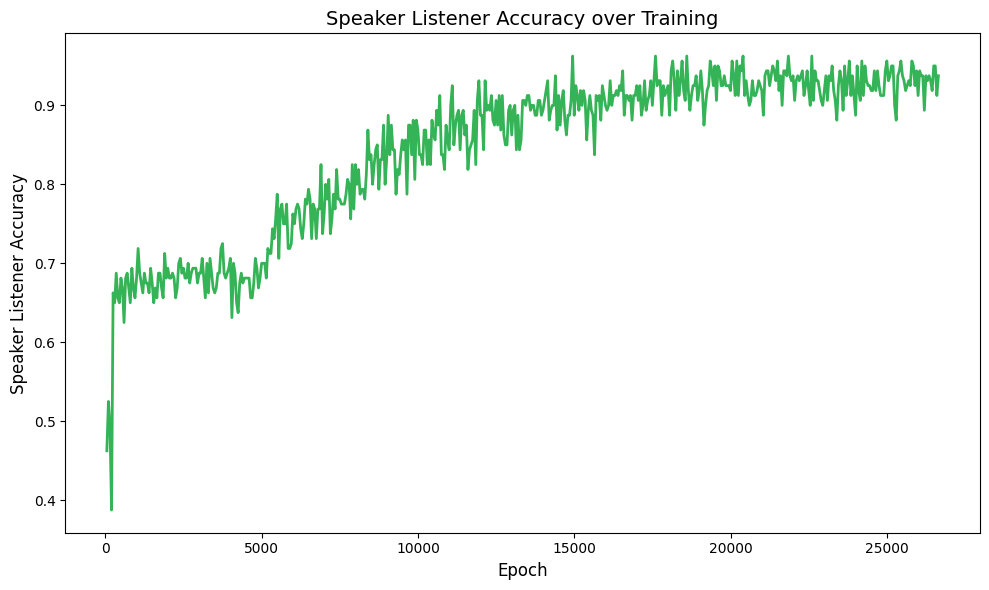

In [21]:
# Training graphs
plot_metric(losses, step_size=50, metric_name='Speaker Listener Loss', save_path='speaker_loss.png')
plot_metric(accuracies, step_size=50, metric_name='Speaker Listener Accuracy', save_path='speaker_accuracy.png')

### Inference

In [31]:
print("\n--- Running a test example ---")

# Set model to evaluation mode
model.eval() 
with torch.no_grad():
    W_test, X_test_mask = dataset_splits['speaker_listener']['W'][0:1], dataset_splits['speaker_listener']['X_mask'][0:1]

    # dummy data
    # generate_batch(1, WORLD_SIZE)
    
    print("Test World W has 5 objects.")
    print(f"Target set X is selected by mask: {X_test_mask[0]}")
    
    
    y_test_logits, y_test_labels = model(W_test, X_test_mask)
    y_test_probs  = torch.sigmoid(y_test_logits)

    print(f"Ground truth vector: {y_test_labels.numpy().flatten()}")
    
    print(f"Model prediction (probabilities): {y_test_probs.numpy().flatten()}")
    print(f"Final prediction (rounded): {[round(p, 2) for p in y_test_probs.numpy().flatten()]}")


--- Running a test example ---
Test World W has 5 objects.
Target set X is selected by mask: tensor([0., 1., 1., 1., 1.])
Ground truth vector: [1. 1. 1. 1. 0.]
Model prediction (probabilities): [9.5294100e-01 9.9999976e-01 9.5724666e-01 1.0000000e+00 2.3415541e-07]
Final prediction (rounded): [np.float32(0.95), np.float32(1.0), np.float32(0.96), np.float32(1.0), np.float32(0.0)]


In [ ]:
# Sense check by testing the speaker-listener on translator data

## The Translator

### Prepare Translator Data

In [32]:
   print(dataset_splits['translator_train']['rule_texts'][0:10])

['green and triangle' 'not square' 'purple or square'
 'triangle or slim-outline' 'circle' 'red and circle' 'slim-outline'
 'not thick-outline' 'square' 'red and circle']


In [ ]:
# load the translator training data 

# convert rules to token sequences

### Training

In [ ]:
# run the speaker-listener model and collect neuralese representation V

# batch the data (V, rule_tokens)

# loss

# backward and optimize

### Inference